<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/5_CodingDrillDown/Experiments/MNIST_Step%201_BasicSkeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Target:

- Get the basic skeleton interms of convolution and placement of transition blocks (max pooling, 1x1's)
- Reduce the number of parameters as low as possible



# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


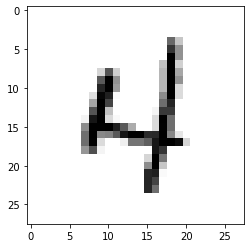

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

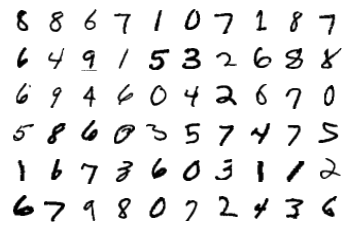

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [7]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,608
              ReLU-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 32, 22, 22]           9,216
              ReLU-6           [-1, 32, 22, 22]               0
         MaxPool2d-7           [-1, 32, 11, 11]               0
            Conv2d-8           [-1, 32, 11, 11]           1,024
              ReLU-9           [-1, 32, 11, 11]               0
           Conv2d-10             [-1, 32, 9, 9]           9,216
             ReLU-11             [-1, 32, 9, 9]               0
           Conv2d-12             [-1, 64, 7, 7]          18,432
             ReLU-13             [-1, 64, 7, 7]               0
           Conv2d-14             [

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training and Testing

All right, so we have 48k params, and that's too many from target size, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 19
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.24923981726169586 Batch_id=468 Accuracy=69.82: 100%|██████████| 469/469 [00:17<00:00, 26.89it/s]



Test set: Average loss: 0.1323, Accuracy: 9615/10000 (96.15%)

EPOCH: 2


Loss=0.14071343839168549 Batch_id=468 Accuracy=96.80: 100%|██████████| 469/469 [00:16<00:00, 27.79it/s]



Test set: Average loss: 0.0676, Accuracy: 9782/10000 (97.82%)

EPOCH: 3


Loss=0.07201037555932999 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:16<00:00, 27.63it/s]



Test set: Average loss: 0.0583, Accuracy: 9816/10000 (98.16%)

EPOCH: 4


Loss=0.035916801542043686 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:17<00:00, 27.57it/s]



Test set: Average loss: 0.0457, Accuracy: 9854/10000 (98.54%)

EPOCH: 5


Loss=0.03633507713675499 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:17<00:00, 27.38it/s]



Test set: Average loss: 0.0478, Accuracy: 9847/10000 (98.47%)

EPOCH: 6


Loss=0.018944932147860527 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:17<00:00, 27.39it/s]



Test set: Average loss: 0.0414, Accuracy: 9869/10000 (98.69%)

EPOCH: 7


Loss=0.04306365177035332 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:17<00:00, 27.51it/s]



Test set: Average loss: 0.0456, Accuracy: 9847/10000 (98.47%)

EPOCH: 8


Loss=0.10328546911478043 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:17<00:00, 27.50it/s]



Test set: Average loss: 0.0373, Accuracy: 9873/10000 (98.73%)

EPOCH: 9


Loss=0.022368719801306725 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:17<00:00, 27.56it/s]



Test set: Average loss: 0.0440, Accuracy: 9865/10000 (98.65%)

EPOCH: 10


Loss=0.08122041076421738 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:17<00:00, 27.14it/s]



Test set: Average loss: 0.0416, Accuracy: 9875/10000 (98.75%)

EPOCH: 11


Loss=0.011142533272504807 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]



Test set: Average loss: 0.0385, Accuracy: 9876/10000 (98.76%)

EPOCH: 12


Loss=0.011320855468511581 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:17<00:00, 27.45it/s]



Test set: Average loss: 0.0420, Accuracy: 9870/10000 (98.70%)

EPOCH: 13


Loss=0.012489770539104939 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:17<00:00, 27.38it/s]



Test set: Average loss: 0.0432, Accuracy: 9872/10000 (98.72%)

EPOCH: 14


Loss=0.011209256015717983 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:16<00:00, 27.75it/s]



Test set: Average loss: 0.0393, Accuracy: 9887/10000 (98.87%)

EPOCH: 15


Loss=0.006021682173013687 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:17<00:00, 27.17it/s]



Test set: Average loss: 0.0393, Accuracy: 9888/10000 (98.88%)

EPOCH: 16


Loss=0.0018665454117581248 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:16<00:00, 27.69it/s]



Test set: Average loss: 0.0396, Accuracy: 9886/10000 (98.86%)

EPOCH: 17


Loss=0.027625886723399162 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:16<00:00, 27.93it/s]



Test set: Average loss: 0.0466, Accuracy: 9878/10000 (98.78%)

EPOCH: 18


Loss=0.04052726551890373 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:16<00:00, 27.84it/s]



Test set: Average loss: 0.0453, Accuracy: 9882/10000 (98.82%)

EPOCH: 19


Loss=0.03701334446668625 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:16<00:00, 27.90it/s]



Test set: Average loss: 0.0421, Accuracy: 9887/10000 (98.87%)



Text(0.5, 1.0, 'Test Accuracy')

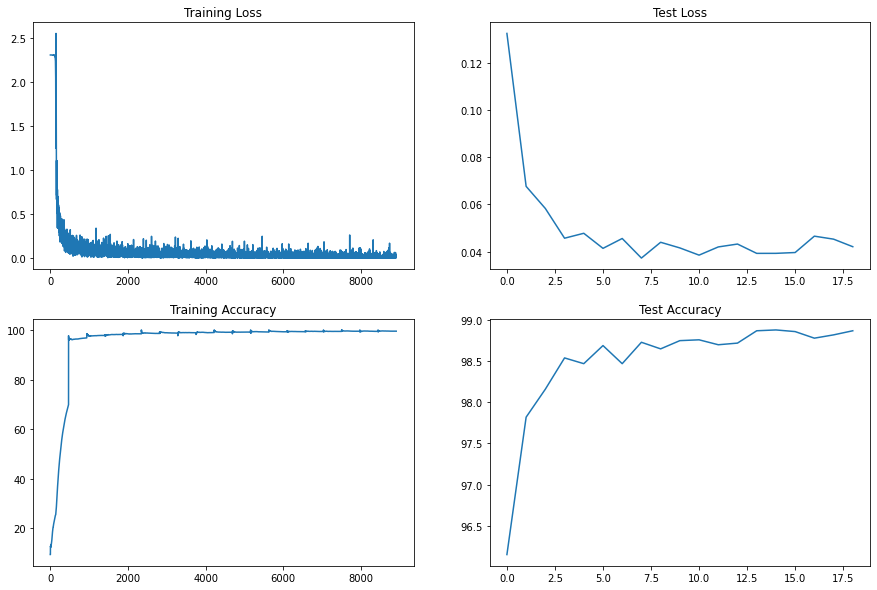

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Results:
- Parameters: 48,180
- Best Training Accuracy: 99.50
- Best Test Accuracy: 98.87

## Analysis:
- We have structured our model in a readable way
- The model is lighter with less number of parameters 
- The performace is reduced compared to previous models. Since we have reduced model capacity, this is expected, the model has capability to learn.   
- Next, we will be tweaking this model further and increase the capacity to push it more towards the desired accuracy.